#  Setup

In [220]:
!pip install pybaseball
import pybaseball
from pybaseball import statcast, statcast_pitcher, playerid_lookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pybaseball.cache.enable()
data = statcast('2022-04-07', '2022-10-05')

print(data.shape)
data.head(10)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.8/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████| 182/182 [13:44<00:00,  4.53s/it]


(708540, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3171,CH,2022-10-05,80.8,-0.76,6.61,"Baker, Bryan",624415,641329,field_out,hit_into_play,...,5,4,5,4,5,Infield shift,Standard,213,0.035,-0.099
3387,FF,2022-10-05,97.7,-0.58,6.6,"Baker, Bryan",643376,641329,strikeout,swinging_strike,...,5,4,5,4,5,Standard,Standard,189,0.052,-0.134
3467,CH,2022-10-05,84.9,-0.55,6.58,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,212,0.0,0.023
3590,FF,2022-10-05,97.2,-0.42,6.6,"Baker, Bryan",643376,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.036
3846,FC,2022-10-05,86.2,-0.55,6.64,"Baker, Bryan",643376,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,127,0.0,-0.031
3886,FF,2022-10-05,97.5,-0.56,6.68,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,194,0.0,0.023
4028,CH,2022-10-05,84.9,-0.58,6.65,"Baker, Bryan",665489,641329,strikeout,called_strike,...,5,4,5,4,5,Standard,Standard,207,0.071,-0.158
4181,FF,2022-10-05,98.2,-0.59,6.72,"Baker, Bryan",665489,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,190,0.0,0.017
4387,CH,2022-10-05,83.8,-0.41,6.57,"Baker, Bryan",665489,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,211,0.0,-0.046
4557,FF,2022-10-05,96.7,-0.41,6.75,"Baker, Bryan",665489,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.034


In [115]:
data = pd.read_csv('data2022.csv')
data.shape

(96294, 93)

# Data Cleaning

## Determining Training Data Columns

In [177]:
for i in zip(data.columns, data.dtypes):
  print(i)

('pitcher', dtype('int64'))
('player_name', dtype('O'))
('pitch_type', dtype('O'))
('p_throws', dtype('O'))
('pitch_name', dtype('O'))
('release_spin_rate', dtype('float64'))
('release_speed', dtype('float64'))
('effective_speed', dtype('float64'))
('spin_axis', dtype('float64'))
('vx0', dtype('float64'))
('vy0', dtype('float64'))
('vz0', dtype('float64'))
('ax', dtype('float64'))
('ay', dtype('float64'))
('az', dtype('float64'))
('pfx_x', dtype('float64'))
('pfx_z', dtype('float64'))
('plate_x', dtype('float64'))
('plate_z', dtype('float64'))


https://baseballsavant.mlb.com/csv-docs 

Which columns should we keep based on the documentation? Any metrics derived from the movement of the pitch alone, with no regard for the pitcher who threw it except for the handedness of the pitcher.
  - Motivation: different pitch mixes for different hands of pitchers (e.g. more right-handed changeups than left-handed)

In [178]:
data = data[['pitcher', 'player_name', 'pitch_type', "p_throws",'pitch_name', 'release_spin_rate', 'release_speed','effective_speed', 'spin_axis', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z']]

In [179]:
for i in zip(data.columns, data.dtypes):
  print(i)

('pitcher', dtype('int64'))
('player_name', dtype('O'))
('pitch_type', dtype('O'))
('p_throws', dtype('O'))
('pitch_name', dtype('O'))
('release_spin_rate', dtype('float64'))
('release_speed', dtype('float64'))
('effective_speed', dtype('float64'))
('spin_axis', dtype('float64'))
('vx0', dtype('float64'))
('vy0', dtype('float64'))
('vz0', dtype('float64'))
('ax', dtype('float64'))
('ay', dtype('float64'))
('az', dtype('float64'))
('pfx_x', dtype('float64'))
('pfx_z', dtype('float64'))
('plate_x', dtype('float64'))
('plate_z', dtype('float64'))


In [180]:
pitch_names = data.pitch_name.value_counts()
pitch_names

4-Seam Fastball    31160
Slider             19961
Sinker             15828
Changeup           10662
Curveball           8381
Cutter              7067
Knuckle Curve       2014
Split-Finger        1072
Fastball             100
Eephus                48
Name: pitch_name, dtype: int64

In [181]:
pitch_types = data.pitch_type.value_counts()
pitch_types

FF    31160
SL    19961
SI    15828
CH    10662
CU     8378
FC     7067
KC     2014
FS     1072
FA      100
EP       48
CS        4
Name: pitch_type, dtype: int64

In [182]:
data[data['pitch_name'] == 'Fastball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
6761,620443,"Torrens, Luis",FA,R,Fastball,2028.0,88.8,87.4,198.0,5.908894,-129.211593,-6.160026,-9.017058,23.988244,-16.007847,-0.70,1.34,0.83,2.94
6762,620443,"Torrens, Luis",FA,R,Fastball,2013.0,87.1,86.0,210.0,7.767040,-126.695007,-5.562338,-13.780615,23.249160,-19.449337,-1.14,1.09,0.36,2.11
6763,620443,"Torrens, Luis",FA,R,Fastball,2006.0,84.8,83.5,215.0,5.576926,-123.404175,-4.159193,-5.468194,23.603541,-16.933643,-0.43,1.43,0.36,2.97
6764,620443,"Torrens, Luis",FA,R,Fastball,1920.0,85.1,84.2,205.0,8.035447,-123.709060,-4.118744,-8.744140,22.830860,-21.535999,-0.70,0.97,1.11,2.37
6765,620443,"Torrens, Luis",FA,R,Fastball,1929.0,86.6,85.1,197.0,10.013253,-125.686932,-5.303777,-13.215244,24.124622,-19.228439,-1.06,1.13,1.72,2.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77701,608348,"Kelly, Carson",FA,R,Fastball,1173.0,51.1,49.6,207.0,2.222860,-74.389743,1.533041,-1.760187,9.518831,-26.495785,-0.40,1.65,-0.47,2.51
77702,608348,"Kelly, Carson",FA,R,Fastball,1184.0,52.0,50.3,206.0,3.692545,-75.571902,0.292144,-1.734374,9.959260,-25.672188,-0.33,1.78,0.63,1.79
77703,608348,"Kelly, Carson",FA,R,Fastball,1300.0,54.1,52.1,208.0,3.248488,-78.696963,1.447770,-1.281531,11.338169,-24.700352,-0.20,1.93,0.35,3.33
77716,608348,"Kelly, Carson",FA,R,Fastball,1206.0,53.7,51.7,205.0,2.703300,-78.109933,0.367617,-1.345380,11.595912,-24.806660,-0.23,1.90,-0.16,2.39


In [183]:
data[data['pitch_name'] == 'Fastball'].player_name.value_counts()

Alberto, Hanser       35
Torrens, Luis         15
McKenna, Ryan         15
Dickerson, Corey      12
Kelly, Carson          9
Maton, Nick            3
Palacios, Jermaine     3
Vargas, Ildemaro       2
Lopez, Alejo           2
Arcia, Orlando         2
Clemens, Kody          1
Stubbs, Garrett        1
Name: player_name, dtype: int64

In [184]:
data[data['pitch_name'] == 'Eephus']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
22034,545121,"Vargas, Ildemaro",EP,R,Eephus,841.0,38.6,37.1,204.0,0.657855,-54.456680,11.293683,0.051253,5.996353,-30.418288,0.06,1.67,-0.16,4.32
22036,545121,"Vargas, Ildemaro",EP,R,Eephus,812.0,38.9,37.2,216.0,-0.237409,-54.731675,12.313730,-0.238409,5.931549,-30.790850,-0.13,1.51,-0.99,5.20
22038,545121,"Vargas, Ildemaro",EP,R,Eephus,898.0,39.0,37.6,214.0,1.599343,-55.654232,9.203681,-0.112455,6.065402,-29.648962,0.03,1.86,0.50,2.68
22039,545121,"Vargas, Ildemaro",EP,R,Eephus,786.0,38.8,37.7,200.0,-0.054562,-55.025723,10.620663,0.609237,4.665442,-30.573263,0.30,1.33,-0.71,3.81
23315,665019,"Clemens, Kody",EP,R,Eephus,1042.0,46.1,44.3,201.0,0.513493,-66.848762,5.700501,-0.052311,5.908564,-28.959118,0.00,1.28,-0.85,3.74
23316,665019,"Clemens, Kody",EP,R,Eephus,1218.0,59.9,58.3,201.0,0.647720,-87.370846,-0.226810,1.707023,11.299112,-23.731711,0.35,1.67,-1.03,2.67
23318,665019,"Clemens, Kody",EP,R,Eephus,1259.0,59.4,57.4,198.0,1.318041,-86.473664,0.163884,5.096068,13.208701,-24.609771,1.06,1.57,0.19,2.69
23319,665019,"Clemens, Kody",EP,R,Eephus,1322.0,63.3,61.6,205.0,-1.814574,-92.219778,0.044322,1.594258,12.705120,-24.206130,0.23,1.42,-2.79,3.15
23320,665019,"Clemens, Kody",EP,R,Eephus,1154.0,57.6,55.7,203.0,0.629410,-83.847856,0.714463,-0.192832,10.946945,-24.482142,-0.02,1.69,-1.22,2.97
23321,665019,"Clemens, Kody",EP,R,Eephus,1150.0,58.0,55.9,201.0,1.637669,-84.365289,0.394140,3.304114,12.394535,-23.892935,0.75,1.81,0.38,2.84


In [185]:
data[data['pitch_name'] == 'Eephus'].player_name.value_counts()

Clemens, Kody         13
Lopez, Alejo          12
Arcia, Orlando         8
Dickerson, Corey       6
Vargas, Ildemaro       4
Stubbs, Garrett        4
Palacios, Jermaine     1
Name: player_name, dtype: int64

In [186]:
# Knuckeballs
data[data['pitch_name'] == 'Knuckleball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z


In [187]:
data[data['pitch_name'] == 'Knuckleball'].player_name.value_counts()

Series([], Name: player_name, dtype: int64)

In [188]:
# number of rows to delete
pitch_names[-3:].sum()

1220

In [189]:
df = data.loc[~((data['pitch_type'] == 'FA') | (data['pitch_type'] == 'EP') | (data['pitch_type'] == 'KN'))]
df.shape

(96146, 19)

In [190]:
print(data.shape[0] - df.shape[0])

148


In [191]:
df

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,641329,"Baker, Bryan",CH,R,Changeup,1771.0,80.8,81.5,213.0,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.80,-0.32,2.24
1,641329,"Baker, Bryan",FF,R,4-Seam Fastball,2434.0,97.7,98.1,189.0,2.238826,-142.091777,-8.968560,-2.851911,33.061824,-8.887788,-0.17,1.58,0.10,2.59
2,641329,"Baker, Bryan",CH,R,Changeup,1856.0,84.9,85.2,212.0,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,641329,"Baker, Bryan",FF,R,4-Seam Fastball,2258.0,97.2,97.5,192.0,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.30
4,641329,"Baker, Bryan",FC,R,Cutter,2348.0,86.2,86.7,127.0,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.00,0.36,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,468504,"Chacín, Jhoulys",SI,R,Sinker,2235.0,92.5,92.1,213.0,9.298054,-134.472632,-4.836055,-14.062812,27.166967,-24.593246,-1.00,0.55,0.52,2.33
96290,468504,"Chacín, Jhoulys",SI,R,Sinker,2131.0,91.5,91.5,213.0,7.070429,-133.208810,-4.052117,-13.304866,23.613234,-26.898619,-1.00,0.39,0.00,2.60
96291,468504,"Chacín, Jhoulys",CU,R,Curveball,2613.0,76.6,76.4,69.0,0.229515,-111.737410,0.477042,11.283207,17.966375,-32.017368,1.34,0.05,-0.67,3.09
96292,468504,"Chacín, Jhoulys",SI,R,Sinker,2273.0,90.4,90.2,209.0,3.109496,-131.788891,-4.513370,-9.600318,23.198957,-22.708626,-0.77,0.75,-1.28,2.59


## Missing Values

In [192]:
df.isnull().sum()

pitcher                0
player_name            0
pitch_type             0
p_throws               0
pitch_name             1
release_spin_rate    166
release_speed          6
effective_speed       21
spin_axis            159
vx0                    0
vy0                    0
vz0                    0
ax                     0
ay                     1
az                     1
pfx_x                  0
pfx_z                  0
plate_x                0
plate_z                0
dtype: int64

In [193]:
# Example: Find pitchers who have spin rate metrics that are "missing"
df[df['release_spin_rate'].isna()].player_name.value_counts()

Hernández, Carlos       34
Civale, Aaron           21
Weaver, Luke            18
Morgan, Eli             14
De Los Santos, Enyel    13
Stephan, Trevor          8
Heasley, Jonathan        8
Miller, Tyson            8
Davidson, Tucker         4
King, John               3
Kaprielian, James        2
Wentz, Joey              2
Davies, Zach             2
Webb, Logan              2
Leclerc, José            2
Singer, Brady            2
Young, Alex              2
Law, Derek               1
Springs, Jeffrey         1
Rodriguez, Eduardo       1
Wright, Kyle             1
Kremer, Dean             1
Rodón, Carlos            1
Stephens, Jackson        1
Milner, Hoby             1
Cleavinger, Garrett      1
Bruihl, Justin           1
Oviedo, Johan            1
Wainwright, Adam         1
Loup, Aaron              1
Widener, Taylor          1
Mantiply, Joe            1
Pérez, Cionel            1
Espino, Paolo            1
Kuhnel, Joel             1
Fairbanks, Pete          1
Helsley, Ryan            1
C

Option A: Go through all missing metrics for each pitcher, take their averages for each column and fill in all missing values with average

Option B: Delete all rows that contain *any* missing values

In [194]:
# Number of rows with missing values
missing_row_vals = df.isna().any(axis=1).sum()
print(missing_row_vals)
# Error proportion relative to whole regular season dataset
print('Percentage Error of Statcast',round(100 * (missing_row_vals / data.shape[0]), 2))

180
Percentage Error of Statcast 0.19


In [195]:
# Remove all rows containing missing values
num_rows1 = df.shape[0]

# Drop NaN rows and reset indices
df = df.dropna()
df = df.drop(['pitch_type'], axis=1)
df = df.reset_index(drop = True)

print(df.shape)
print('Number of rows removed:', num_rows1 - df.shape[0])

(95966, 18)
Number of rows removed: 180


In [196]:
df

,pitcher,player_name,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,641329,"Baker, Bryan",R,Changeup,1771.0,80.8,81.5,213.0,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.80,-0.32,2.24
1,641329,"Baker, Bryan",R,4-Seam Fastball,2434.0,97.7,98.1,189.0,2.238826,-142.091777,-8.968560,-2.851911,33.061824,-8.887788,-0.17,1.58,0.10,2.59
2,641329,"Baker, Bryan",R,Changeup,1856.0,84.9,85.2,212.0,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,641329,"Baker, Bryan",R,4-Seam Fastball,2258.0,97.2,97.5,192.0,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.30
4,641329,"Baker, Bryan",R,Cutter,2348.0,86.2,86.7,127.0,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.00,0.36,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95961,668678,"Gallen, Zac",R,4-Seam Fastball,2396.0,93.6,94.2,213.0,6.031231,-136.301856,-3.425586,-4.442274,25.083570,-16.503906,-0.26,1.20,-0.99,3.42
95962,468504,"Chacín, Jhoulys",R,Sinker,2235.0,92.5,92.1,213.0,9.298054,-134.472632,-4.836055,-14.062812,27.166967,-24.593246,-1.00,0.55,0.52,2.33
95963,468504,"Chacín, Jhoulys",R,Sinker,2131.0,91.5,91.5,213.0,7.070429,-133.208810,-4.052117,-13.304866,23.613234,-26.898619,-1.00,0.39,0.00,2.60
95964,468504,"Chacín, Jhoulys",R,Curveball,2613.0,76.6,76.4,69.0,0.229515,-111.737410,0.477042,11.283207,17.966375,-32.017368,1.34,0.05,-0.67,3.09


# Analysis

In [ ]:
df.p_throws.value_counts()

# Preprocessing

## Encoding Categorical Columns

In [197]:
X = df.drop(['pitcher',	'player_name', 'pitch_name'], axis=1)
y = df['pitch_name']

In [198]:
label_encoder = LabelEncoder()    

X['p_throws'] = label_encoder.fit_transform(X['p_throws'])
X

,p_throws,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,1,1771.0,80.8,81.5,213.0,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.80,-0.32,2.24
1,1,2434.0,97.7,98.1,189.0,2.238826,-142.091777,-8.968560,-2.851911,33.061824,-8.887788,-0.17,1.58,0.10,2.59
2,1,1856.0,84.9,85.2,212.0,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,1,2258.0,97.2,97.5,192.0,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.30
4,1,2348.0,86.2,86.7,127.0,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.00,0.36,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95961,1,2396.0,93.6,94.2,213.0,6.031231,-136.301856,-3.425586,-4.442274,25.083570,-16.503906,-0.26,1.20,-0.99,3.42
95962,1,2235.0,92.5,92.1,213.0,9.298054,-134.472632,-4.836055,-14.062812,27.166967,-24.593246,-1.00,0.55,0.52,2.33
95963,1,2131.0,91.5,91.5,213.0,7.070429,-133.208810,-4.052117,-13.304866,23.613234,-26.898619,-1.00,0.39,0.00,2.60
95964,1,2613.0,76.6,76.4,69.0,0.229515,-111.737410,0.477042,11.283207,17.966375,-32.017368,1.34,0.05,-0.67,3.09


In [199]:
X.dtypes

p_throws               int64
release_spin_rate    float64
release_speed        float64
effective_speed      float64
spin_axis            float64
vx0                  float64
vy0                  float64
vz0                  float64
ax                   float64
ay                   float64
az                   float64
pfx_x                float64
pfx_z                float64
plate_x              float64
plate_z              float64
dtype: object

In [200]:
y

0               Changeup
1        4-Seam Fastball
2               Changeup
3        4-Seam Fastball
4                 Cutter
              ...       
95961    4-Seam Fastball
95962             Sinker
95963             Sinker
95964          Curveball
95965             Sinker
Name: pitch_name, Length: 95966, dtype: object

In [201]:
label_encoder2 = LabelEncoder()

y = label_encoder2.fit_transform(y)
y

array([1, 0, 1, ..., 5, 2, 5])

In [261]:
pitch_df = pd.DataFrame()
pitch_df['label'] = df['pitch_name']
pitch_df['encoded'] = y.tolist()
pitch_encoded = pitch_df.value_counts(sort=False, ascending=False)

In [262]:
pitch_encoded

label            encoded
4-Seam Fastball  0          31087
Changeup         1          10636
Curveball        2           8367
Cutter           3           7054
Knuckle Curve    4           2008
Sinker           5          15815
Slider           6          19935
Split-Finger     7           1064
dtype: int64

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0) 

## Standardization

In [203]:
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# Model Construction

Naïve Bayes, Decision trees, Random forest classifier, KNN, and logistic regression

https://www.analyticssteps.com/blogs/how-does-k-nearest-neighbor-works-machine-learning-classification-problem


https://www.analyticssteps.com/blogs/what-naive-bayes-algorithm-machine-learning

https://www.analyticssteps.com/blogs/how-use-random-forest-classifier-machine-learning



https://adityagoel123.medium.com/multi-class-classification-using-decision-tree-model-68e75114303




https://www.javatpoint.com/data-preprocessing-machine-learning


## K-Nearest Neighbors

In [206]:
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)

KNeighborsClassifier()

In [211]:
y_pred = KNN.predict(X_test)

In [214]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[6048,    8,    0,   46,    0,  173,    4,    0],
       [   4, 1960,    2,    2,    0,  118,    5,   43],
       [   0,    0, 1370,    6,   60,    0,  223,    0],
       [  92,    4,    3,  996,    1,    2,  285,    1],
       [   0,    1,  160,    0,  227,    0,   39,    0],
       [ 313,   75,    0,    6,    0, 2716,    0,    3],
       [  16,   14,  154,  232,   25,    1, 3528,    0],
       [   0,  126,    0,    0,    0,    6,    1,   95]])

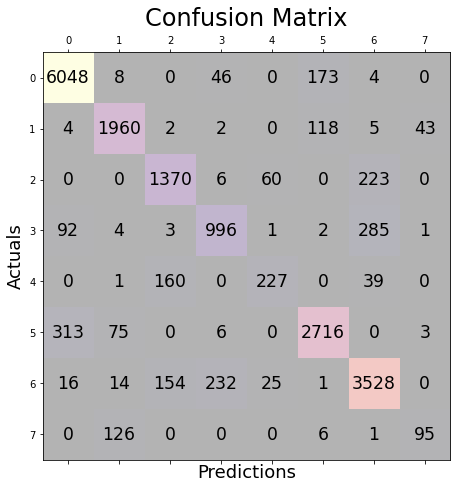

In [247]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.inferno, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=24)
plt.show()

In [248]:
rows = conf_matrix.sum(axis = 1, keepdims = True)
normalized_matrix = conf_matrix / rows

np.fill_diagonal(normalized_matrix, 0)
normalized_matrix = np.round_(normalized_matrix, 4)
normalized_matrix

array([[0.000e+00, 1.300e-03, 0.000e+00, 7.300e-03, 0.000e+00, 2.760e-02,
        6.000e-04, 0.000e+00],
       [1.900e-03, 0.000e+00, 9.000e-04, 9.000e-04, 0.000e+00, 5.530e-02,
        2.300e-03, 2.010e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, 3.600e-03, 3.620e-02, 0.000e+00,
        1.344e-01, 0.000e+00],
       [6.650e-02, 2.900e-03, 2.200e-03, 0.000e+00, 7.000e-04, 1.400e-03,
        2.059e-01, 7.000e-04],
       [0.000e+00, 2.300e-03, 3.747e-01, 0.000e+00, 0.000e+00, 0.000e+00,
        9.130e-02, 0.000e+00],
       [1.005e-01, 2.410e-02, 0.000e+00, 1.900e-03, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e-03],
       [4.000e-03, 3.500e-03, 3.880e-02, 5.840e-02, 6.300e-03, 3.000e-04,
        0.000e+00, 0.000e+00],
       [0.000e+00, 5.526e-01, 0.000e+00, 0.000e+00, 0.000e+00, 2.630e-02,
        4.400e-03, 0.000e+00]])

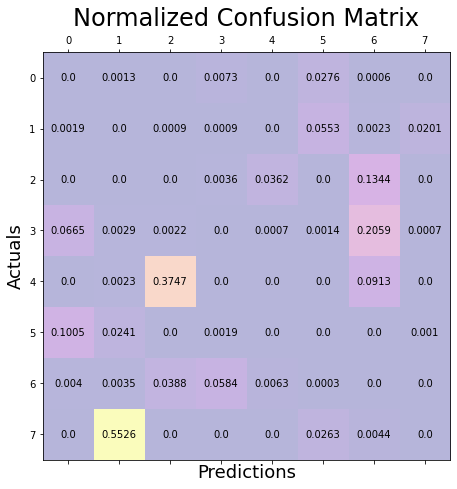

In [249]:


fig2, ax2 = plt.subplots(figsize=(7.5, 7.5))
ax2.matshow(normalized_matrix, cmap=plt.cm.plasma, alpha=0.3)

for i in range(normalized_matrix.shape[0]):
  for j in range(normalized_matrix.shape[1]):
    ax2.text(x=j, y=i,s=normalized_matrix[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Normalized Confusion Matrix', fontsize=24)
plt.show()

In [263]:
# Recall what pitches were encoded to what number
pitch_encoded

label            encoded
4-Seam Fastball  0          31087
Changeup         1          10636
Curveball        2           8367
Cutter           3           7054
Knuckle Curve    4           2008
Sinker           5          15815
Slider           6          19935
Split-Finger     7           1064
dtype: int64

Findings:
* Some sinkers are misclassified as 4-seams
*   The most alarming error is in splitters that are predicted as changeups. The inverse is not true, meaning that the model is not good at telling splitters from changeups given an instance of a splitter, but is good at predicting instances of changeups correctly and telling them from splitters.
*   Curveballs (both kinds) and cutters are misclassified as sliders



In [264]:
print("Testing set accuracy: ", KNN.score(X_test, y_test))
print("Training set accuracy: ", KNN.score(X_train, y_train))

Test accuracy:  0.8825674690007294
Train accuracy:  0.9209086646173084


In [ ]:
print(classification_report(y_test, y_pred))

##Naive Bayes

## Random Forest Classifier